In [1]:
import scipy
import numpy as np
import pandas as pd
import itertools as it

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift, estimate_bandwidth

from scipy.stats import invgamma 
from scipy.stats import beta

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

from IPython.display import clear_output

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

from structure_tools.StructE_tools import findPhiPT, Structure_profiles, Distance_profiles

from structure_tools.AMOVA_func import amova_cofactor, AMOVA_FM42



# MeanShift for structure analysis

This notebook is devoted to describing a process through which to categorize and represent local genomic structure.

Genome wide data has heralded a new paradigm in the study of population genetics. The ability to characterise reduced genomic regions has led to an increased appreciation of the degree of admixture in natural populations and of its impact on estimates of population diversity. 

While a knowledge of the position of local samples in an inclusive evolutionary history could be useful for both the reconstruction of genome history and for association studies, current approaches are still far from meeting this goal. A bibliographic analysis will in fact reveal the majority to consist in informed classification approaches (Geza et al. 2018). For association purposes a categorical output presents limited uses. Some approaches provide estimates of time since divergence, but the same can be said regarding this information. Similar problems surround the application of these methods for population genetic analysis when dealing with natural data. The requirements for inference force the researcher to make strong assumptions regarding his data. 

The solution to this problem has historically been to regard the data under an acceptedly large range of assumptions and to determine which combination is more likely. With consideration for model based approaches, it can be argued that their application to novel data sets is a risky business (we cannot assume to make allowance for every possible factor).  

In Summary,  there is a case for the development of tools for the exploration of genomic data. The prerogative is then to find descriptors that relate fundamental properties of the data. In this notebook we tackle structure. The analysis of Among and Within group variation is a common approach in population genetics. But what about the groups that underlie these statistics? While genome-wide analyses of structure in variance components are common, clustering of local genomic data is usually only used as co-factor to parameterized inference. Why? Bluntly, because how are we to compare clustering results, categorical by nature, across data sets?

It is at this juncture then that we find room for development. This notebook explores the use of Mean Shift clustering to capture and relate local clusters.


## Index


- **I. Study protocol** Define structure and degree of admixture across data sets. 
    - **A. Simulations**
    - **B. Complementary Data**
- **II. Data analysis**
    - **A. Local among population variation**
    - **B. Data structure**
    - **C. MeanShift cluster analysis**
    - **D. Cluster imprint**
- **III. Application**

### References

- Geza E, Mugo J, Mulder NJ, Wonkam A, Chimusa ER, Mazandu GK. 2018. A comprehensive survey of models for dissecting local ancestry deconvolution in human genome. Brief Bioinform bby044-bby044. http://dx.doi.org/10.1093/bib/bby044.


## I. Study protocol.

Construct of a structural series encompassing the range of situations in which to test our statistics.

The next blocks are devoted to the simulations of population samples. First, in the next block, the number of markers is selected and a data set of allele frequency vectors created ([notebook 1. Generating Haplotypes](https://nbviewer.jupyter.org/github/SantosJGND/Genetic-data-analysis/blob/master/Notebooks/1.%20Generating_haplotypes.ipynb), [Stats Lab](https://github.com/SantosJGND/Stats_Lab)). 

After that are defined the specifics of the simulations. The protocol followed here is described in more detail in the notebook [Simulating Genomes](https://nbviewer.jupyter.org/github/SantosJGND/Tools_and_toys/blob/master/Simulate_genomes/Genomic%20structure%20Simulator.ipynb), which showcases the models of admixture and structure currently available.


In [2]:
from structure_tools.Generate_freq_vectors import generate_vectors_Beta

L= 150 # number of markers for each window.
n= 100 # number of vectors produced for each combination of Beta parameters.

rangeA= [1,2.5] # range of parameter a (beta).
rangeB = [.1,.6] # range of parameter b (beta).
steps= 20 # steps along ranges.

n_comp = L # components to keep during PCA of vector data set.

vector_lib= generate_vectors_Beta(L,n,rangeA,rangeB,steps,n_comp)

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized').fit(vector_lib)
features = pca.transform(vector_lib)

print(features.shape)
print(vector_lib.shape)

(2000, 150)
(2000, 150)


In [3]:
from structure_tools.Structure_priors import *
from structure_tools.Recombination_tools import *
from structure_tools.Generate_samples import OriginbySNMF

inclusion_threshold= .8


Geno_Q = "Complementary_data/sNMF_out4K.Q"
Geneo, Ind_admx = OriginbySNMF(Geno_Q,inclusion_threshold)

Sizes= [100,70,200,150]
steps= 100

Npops= len(Sizes)
range_diff= [0,steps]

# recombination map
Cop_choice= {
    0:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    },
    1:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    },
    2:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    },
    3:{
        'cop_func': Rec_prob_uniform,
        'cop_kwargs': {
            'Cop': 5e-2
        }
    }
}

# Admixture dist.
snmf_sim= {
    0:0,
    1:1,
    2:2,
    3:3
}


### Sample from admixture file in accordance to the directions in snmf_sim.
from random import sample

Origins= {x: np.random.choice(range(len(Geneo[snmf_sim[x]])), Sizes[x], replace= True) for x in snmf_sim.keys()}
Origins= {x: sorted([Geneo[snmf_sim[x]][y] for y in Origins[x]]) for x in Origins.keys()}
Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

labels= [x for x in range(len(Geneo.keys())-1)]
#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1

label_package= {
    'labels':labels,
    'Whose': Whose,
    'ind_to_group': ind_to_group,
    'label_vector': label_vector
}


## II. Simulations

Chose the function of population structure across data sets. Visualize resulting *fst*s across data sets.

In [13]:
from structure_tools.Generate_samples import Check_Path, plot_GenFst, return_fsts2

## Select struct prior function and kwargs
prior_func= alien_prior_III

prior_kwargs= {
    'fst_a': 0,
    'fst_b': .2,
    'region': [.37,.42],
    'target': [0,2],
}


fig, Pops, prior= Check_Path(Npops,vector_lib,prior_func,prior_kwargs,Pops= [],random= True,n_comp= L,range_diff= range_diff,steps= steps)

iplot(fig)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\MS_target\structure_tools\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



In [14]:
########
########
from structure_tools.Generate_samples import Gen_samples_II

window_size= 5e3
Chr= 1


SequenceStore, Fst_windows, Ideo, Out= Gen_samples_II(Pops,Sizes,vector_lib,label_package,Origins,prior_func,prior_kwargs,Cop_choice,window_size= window_size,Chr= Chr,range_diff=range_diff)

...


C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\MS_target\structure_tools\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



Done.


### Complementary Data

Ideogram of sample origin across data sets. Ideogram plots are visual representation of local genomic classifications. Here, we represent the origin of individual samples simulated across data sets. Samples are organised vertically, data sets horizontally. Colors represent population of sampling (see section II).

color index:

- red: pop0
- yellow: pop1
- blue: pop2

adding ideograms...


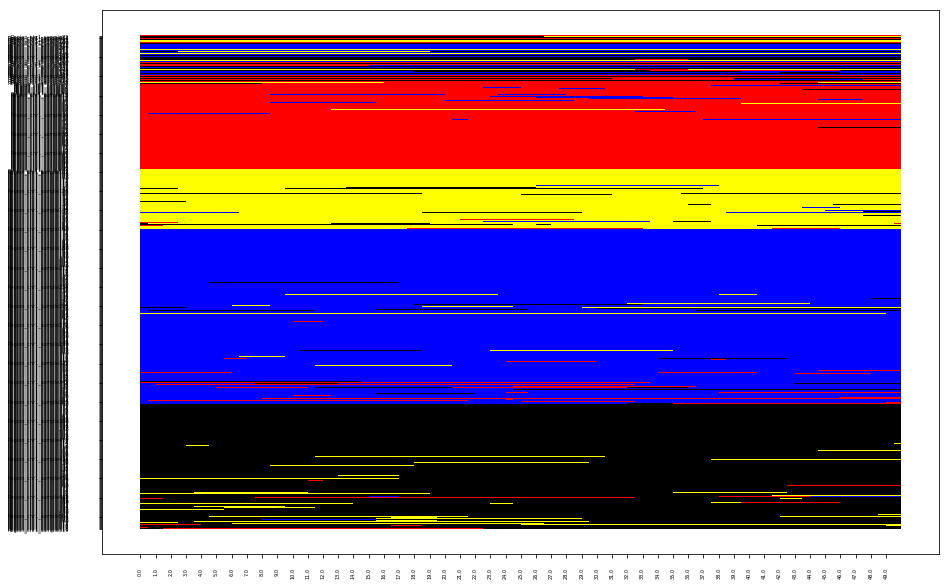

In [18]:
################
################        TRUTH

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
ideo_order= [z for z in it.chain(*list(admx_lib.values()))]

from structure_tools.Ideogram_tools import compress_ideo, return_ideogram, chromosome_collections
import re

import re
chromosome_list= []
chromosomes= [Chr]

for hap in ideo_order:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_chr'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list,Out)

ID= 'truth'

fig= return_ideogram(ideo, chromosome_list,ID,height= 10,width= 15)

## III. Data Analysis

### A. Local among population variation

This section performs analyses of molecular variance across the data sets created.

The user can specify for this effect if the AMOVA is to be conducted using known populations or local clusters estimated using the mean shift algorithm (Comaniciu and Meer 2002). This is defined using the boolean `supervised`.

The function `AMOVA_FM42` returns a tuple: AMOVA stat and significance. The significance statistic calculated is a deviation from the result of permutations using randomized labels and assuming the normality of the resulting distribution. The test is conducted when a number of permutations higher than 0 is provided using the argument `n_boot`. Otherwise 0 is returned (visit the **tool note** for more details)

The `metric` argument of the function `AMOVA_FM42` determines the metric argument passed to `sklearn.metrics.pairwise_distances` (see [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) doc). The metric must be adequate for the input passed. For `manhattan` and `hamming` distances the raw haplotypes are passed, for `euclidean` measurements the projections of samples in PCA space.

- Comaniciu D, Meer P. 2002. Mean shift: a robust approach toward feature space analysis. IEEE Trans Pattern Anal Mach Intell 24: 603–619.
- **tool note**: [AMOVA_tutorial](https://nbviewer.jupyter.org/github/SantosJGND/Tools_and_toys/blob/master/AMOVA/AMOVA_tutorial.ipynb)

In [19]:
supervised= True

Bandwidth_split= 30 # grid split for kde 
KDE_comps= 4 # PCA components to retain
clsize= 15 # minimum cluster size to retain during ms clustering
control_sampling= False
control_N= 100
amova= True # whether to calculate amova.


In [20]:
from structure_tools.StructE_tools import findPhiPT, Structure_profiles, Distance_profiles

from structure_tools.AMOVA_func import amova_cofactor, AMOVA_FM42
from structure_tools.mstutorial_tools import Windows_KDE_amova

### Perform Distance and association analysis on the data sets generated

### Define reference and admixed associations:
### for the purpose of this analysis exploration will be driven by
### structure distance profiles. Since KDE will be used for exploration, 
### a set of accessions can be analysed that do not contribute to 
### distance profiles.

admx_N= 50
admx_indx= np.random.choice(range(sum(Sizes)),admx_N,replace= False)

ref_indx= [x for x in range(sum(Sizes)) if x not in admx_indx]

labels_pops= np.repeat(range(len(Sizes)),Sizes)

##

refs_lib= {x:[i for i in range(sum(Sizes)) if labels_pops[i] == x and i not in admx_indx] for x in range(len(Sizes))}

admx_lib= {(max(refs_lib.keys()) + 1): admx_indx}


admx_lib.update(refs_lib)
import itertools as it

Results, Construct, PC_var= Windows_KDE_amova(SequenceStore,
                                              admx_lib,
                                              refs_lib,
                                              supervised= True,
                                              amova= True,
                                              ncomps= KDE_comps,
                                              clsize= clsize,
                                              Bandwidth_split= Bandwidth_split)

chr 1, where: 495000, supervised: True, n clusters: 4
old: ; jaccard: 0.02367098033295561; PCA euc: 0.22298746859649868; nHam: 0.05523460496712588


In [21]:
AMOVA_stats= [[[Chr,wind,*Results[Chr][wind]] for wind in Results[Chr].keys()] for Chr in Results.keys()]
AMOVA_stats= np.array([y for y in it.chain(*AMOVA_stats)])

Names= ['updt jaccard','updt euc','updt hamming']

fig_data= [go.Scatter(
    x= AMOVA_stats[:,1],
    y= AMOVA_stats[:,x],
    mode= 'markers',
    name= Names[x - 3]
) for x in range(3,6)]

layout = go.Layout(
    title= 'Stats',
    yaxis=dict(
        title='AMOVA'),
    xaxis=dict(
        title='Windows')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

### B. Data structure

Principal component analysis of haplotypes generated, concatenated by sample ID. First three principal components depicted. Colors in the first row represent global source, colors in the second row follow the mean shift clustering of samples in the feature space of PCA.

In [28]:
Haplotypes= np.concatenate(tuple([SequenceStore[1][x] for x in SequenceStore[1].keys()]), axis=1)

from structure_tools.mstutorial_tools import Haplotype_MSlabs


fig, feats, label_select= Haplotype_MSlabs(Haplotypes,label_vector)
iplot(fig)

Number of markers: 15000
Number of individuals: 520
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### C. MeanShift cluster analysis

Parse and visualize local patterns of structure. 

We tackle the problem of identifying and comparing data structure across a great number of data sets. 

In [29]:
Names=['id' + str(x) for x in range(len(Whose))]
Fam= {
    Names[x]:x for x in range(len(Names))
}

Fam.update({
    x:Names[x] for x in range(len(Names))
})

###
Dr_dim= 3

###
focus_subset= False
Geneo= admx_lib
Focus_group= 0

Focus= [Names[x] for x in Geneo[Focus_group]]

###
Dr_var= 'all'
target_var= [0]

##


In [30]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

Method= 'MeanShift'

Cl_store= {
    'MeanShift':{
        'Clusterfunc': MeanShift,
        'cluster_kwargs': {
            'bin_seeding': False,
            'cluster_all': True,
            'min_bin_freq': 15
        }
    },
    'DBscan':{
        'Clusterfunc': DBSCAN,
        'cluster_kwargs': {
            'min_samples': 15
        }
    },
    'Ward':{
        'Clusterfunc': AgglomerativeClustering,
        'cluster_kwargs': {
            'linkage': 'ward',
            'n_clusters': 4
        }
    },
    'Kmeans':{
        'Clusterfunc': KMeans,
        'cluster_kwargs': {
            'random_state': 0,
            'n_clusters': 3
        }
    }
}



In [31]:
from structure_tools.mstutorial_tools import MAC_process

preProc_Clover, Cameo, Coordinates, COMPS, X_se, label_select, Subset, labels1= MAC_process(Construct,
                                                                             Out,
                                                                             Cl_store,
                                                                             refs_lib,
                                                                             Fam,
                                                                             Names= Names,
                                                                             target_var= target_var,
                                                                             Dr_var= Dr_var,
                                                                             focus_subset= focus_subset,
                                                                             Focus= Focus,
                                                                             Dr_dim= Dr_dim,
                                                                             Method= Method)


Clover shape:  (306, 520)
Clover shape:  (306, 520)
focusing Dr on all


In [32]:

from plotly import tools
from structure_tools.mstutorial_tools import KDE_pca

KDE_pca(gp,feats= feats,Cameo= Cameo,label_vector= label_vector,Subset= Subset)

['Global', 'Global', 'cluster 1', 'cluster 1', 'cluster 2', 'cluster 2', 'cluster 3', 'cluster 3', 'cluster 4', 'cluster 4', 'cluster 5', 'cluster 5']
This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]
[ (6,1) x11,y11 ]  [ (6,2) x12,y12 ]



### Cluster imprint.

Ideogram representation of membership to clusters of interest.

Select the groups of MS vectors to visualize using the variable `gp`

In [33]:
from structure_tools.mstutorial_tools import MS_ideogram

gp= 4

MS_threshold= .05
height= 10
width= 5
height_chrom= .5



MS_ideogram(gp,
            MS_threshold,
            preProc_Clover,
            Coordinates,
            label_select,
            Out,
            ideo_order= ideo_order,
            Chr= Chr,
            height_chrom= height_chrom,
            height= height,
            width= width)


## Application

The identification of groups of similar clusters has applications beyond the characterisation of genomic diversity. The variation captured in cluster similarity can now serve as prior to the identification of similar clusters in other data sets.

In the next block we use nearest neighbours classifcation to assign new clusters to the groups identified above. 

This approach is applied to a new data set where a different pattern of structure is replicated along a range of data sets.

We begin by simulating a new sequence of structures.

In [57]:
from structure_tools.Generate_samples import Check_Path, plot_GenFst, return_fsts2

## Select struct prior function and kwargs
prior_func= alien_prior_III

prior_kwargs= {
    'fst_a': 0,
    'fst_b': .2,
    'region': [.54,.72],
    'target': [0,2],
}


fig, Pops_2, prior= Check_Path(Npops,vector_lib,prior_func,prior_kwargs,Pops= [],random= True,n_comp= L,range_diff= range_diff,steps= steps)

iplot(fig)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\MS_target\structure_tools\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



In [35]:
########
########
from structure_tools.Generate_samples import Gen_samples_II

window_size= 5e3
Chr= 1


SequenceStore, Fst_windows, Ideo, Out= Gen_samples_II(Pops,Sizes,vector_lib,label_package,Origins,prior_func,prior_kwargs,Cop_choice,window_size= window_size,Chr= Chr,range_diff=range_diff)

...


C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\MS_target\structure_tools\StructE_tools.py:398: RuntimeWarning:

invalid value encountered in double_scalars



Done.


### Mean Shift - AMOVA across data sets.

Use the clustering of MS vectors performed in **Section II** to classify new observations in PCA space. Uses nneighbours classifier from sklearn ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))

All parameters for the steps are kept the same as for the original analysis:
        - dimensionality reduction: focus and ncomps;
        - MeanShift: clsize and bandwidth_split;


In [37]:

Results, Construct, PC_var= Windows_KDE_amova(SequenceStore,
                                              admx_lib,
                                              refs_lib,
                                              supervised= True,
                                              amova= True,
                                              ncomps= KDE_comps,
                                              clsize= clsize,
                                              Bandwidth_split= Bandwidth_split)


chr 1, where: 495000, supervised: True, n clusters: 4
old: ; jaccard: 0.023300289261867106; PCA euc: 0.23012742727463306; nHam: 0.0542019453152056


In [56]:
from structure_tools.mstutorial_tools import recover_MSgp


recover_MSgp(Construct,COMPS,Out,labels1,refs_lib,Fam,
                                Names= Names,
                                 target_var= target_var,
                                 Dr_var= Dr_var,
                                 focus_subset= focus_subset,
                                 Focus= Focus,
                                 Dr_dim= Dr_dim,
                                 Method= Method)


Clover shape:  (319, 520)
Clover shape:  (319, 520)
focusing Dr on all
(319, 3)


Notice that we identify the same group despite the fact that the changes in distances operated in the simulations of Sections I and III differ. The important aspect here is the threshold distance beyond which mean shift is able to recognise modes (bandwidth and sample size dependent). This  an important observation because of its pertinence for population genetic inference. Insofar as *fst* is indicative of mean genealogic time, we would have characterised two introgressions to roughly the same group but from different origins.

Partial as it is, this information can already be of use.

Next we explore a way of complementing this data in a guided way.